In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
import sys
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.neighbors import NearestNeighbors

# Background
The department of developmental biology is interested in exploring if expression data from a number of genes can be used to identify specific cell types. They used a publicly available dataset to run a pilot study and explore if there are specific patterns in the data supporting their hypothesis (to be used in question number 1). Assuming that their hypothesis would be supported by their analysis, they also initiated a parallel study sequencing their own data, for which the information about each cell type was available (to be used in question 2).

# Goals
To evaluate the performance of different clustering techniques identifying cell types based on gene expression (use only the pilot dataset).

* Compare quantitatively the performance of K-means, DBSCAN and OPTICS identifying clusters of gene expression that may be associated with cell types. Justify parameter selection independently for each algorithm. How similar are the results obtained from the three algorithms?

* What is the most likely number of cell types based on previous results? Justify the answer using only the pilot dataset.

To evaluate the performance of clustering techniques on a separate dataset (use the test dataset).

* Evaluate quantitatively the performance of the previous methods in the new dataset for which the cell types are known.

* Compare the performance of previous clustering techniques with linear discriminant analysis. Justify any difference in the obtained results.


In [2]:
# Set wkdir
WORK_DIR = os.getcwd()

# Import and display data
pilotDataDF = pd.read_excel(f'{WORK_DIR}/Pilot_GeneExpressionData.xlsx')
pilotDataDF.columns = pilotDataDF.columns.str.lower().str.replace('expression - ', '').str.replace(' ', '_')
pilotDataDF.head(5)

,gene_000,gene_001,gene_002,gene_003,gene_004,gene_005,gene_006,gene_007,gene_008,gene_009,...,gene_090,gene_091,gene_092,gene_093,gene_094,gene_095,gene_096,gene_097,gene_098,gene_099
0,-1.237358,38.642584,10.884096,-3.339147,-1.555339,14.407978,55.770644,13.109897,11.652522,365.928797,...,68.662581,1.343553,20.079415,48.342081,5.199666,8.582158,325.058081,413.412361,655.467974,224.045697
1,-2.093798,39.399697,5.863917,-2.270315,-0.486506,9.469040,60.626785,9.492048,17.507333,365.129055,...,79.764261,12.445233,11.953880,52.238938,-0.116666,4.537059,321.012982,413.379518,655.339022,224.529880
2,14.470170,36.381095,-9.510318,15.156488,16.940296,-7.909798,74.697892,-4.465825,12.619979,335.499965,...,73.074749,5.755721,16.613457,55.059154,4.151859,5.631896,322.107819,411.768780,655.437052,224.088647
3,-3.074387,39.030519,9.228330,-3.344361,-1.560553,12.287957,58.692670,11.807070,15.281483,366.153522,...,68.135925,0.816897,22.837977,49.460210,7.882375,8.555372,325.031295,411.803469,655.470397,223.914104
4,-0.898006,39.088386,4.945750,-1.124616,0.659192,8.204751,61.690854,8.721729,16.890130,362.689877,...,77.619769,10.300741,14.478982,50.745263,1.451071,5.621678,322.097601,413.323667,655.363004,224.430544


# EDA & Data Pre-Processing
## Visualize Gene Expression Data

In [3]:
def gene_expression_displot(df, n_col, bins, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of gene expression data
    '''

    # Extract features to plot - only numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    
    # Set figure space
    #plt.style.use('seaborn')
    n_row = int(np.ceil(len(numeric_features)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(numeric_features):
        
        # Plot
        sns.distplot(df[feature], hist=True, kde=False, bins=bins, ax=plots[i])
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_xlabel('')
        if i % n_col == 0:
            plots[i].set_ylabel('Count')
        else:
            plots[i].set_ylabel('')
        
    plt.show()
    


Gene Expression Distributions:



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


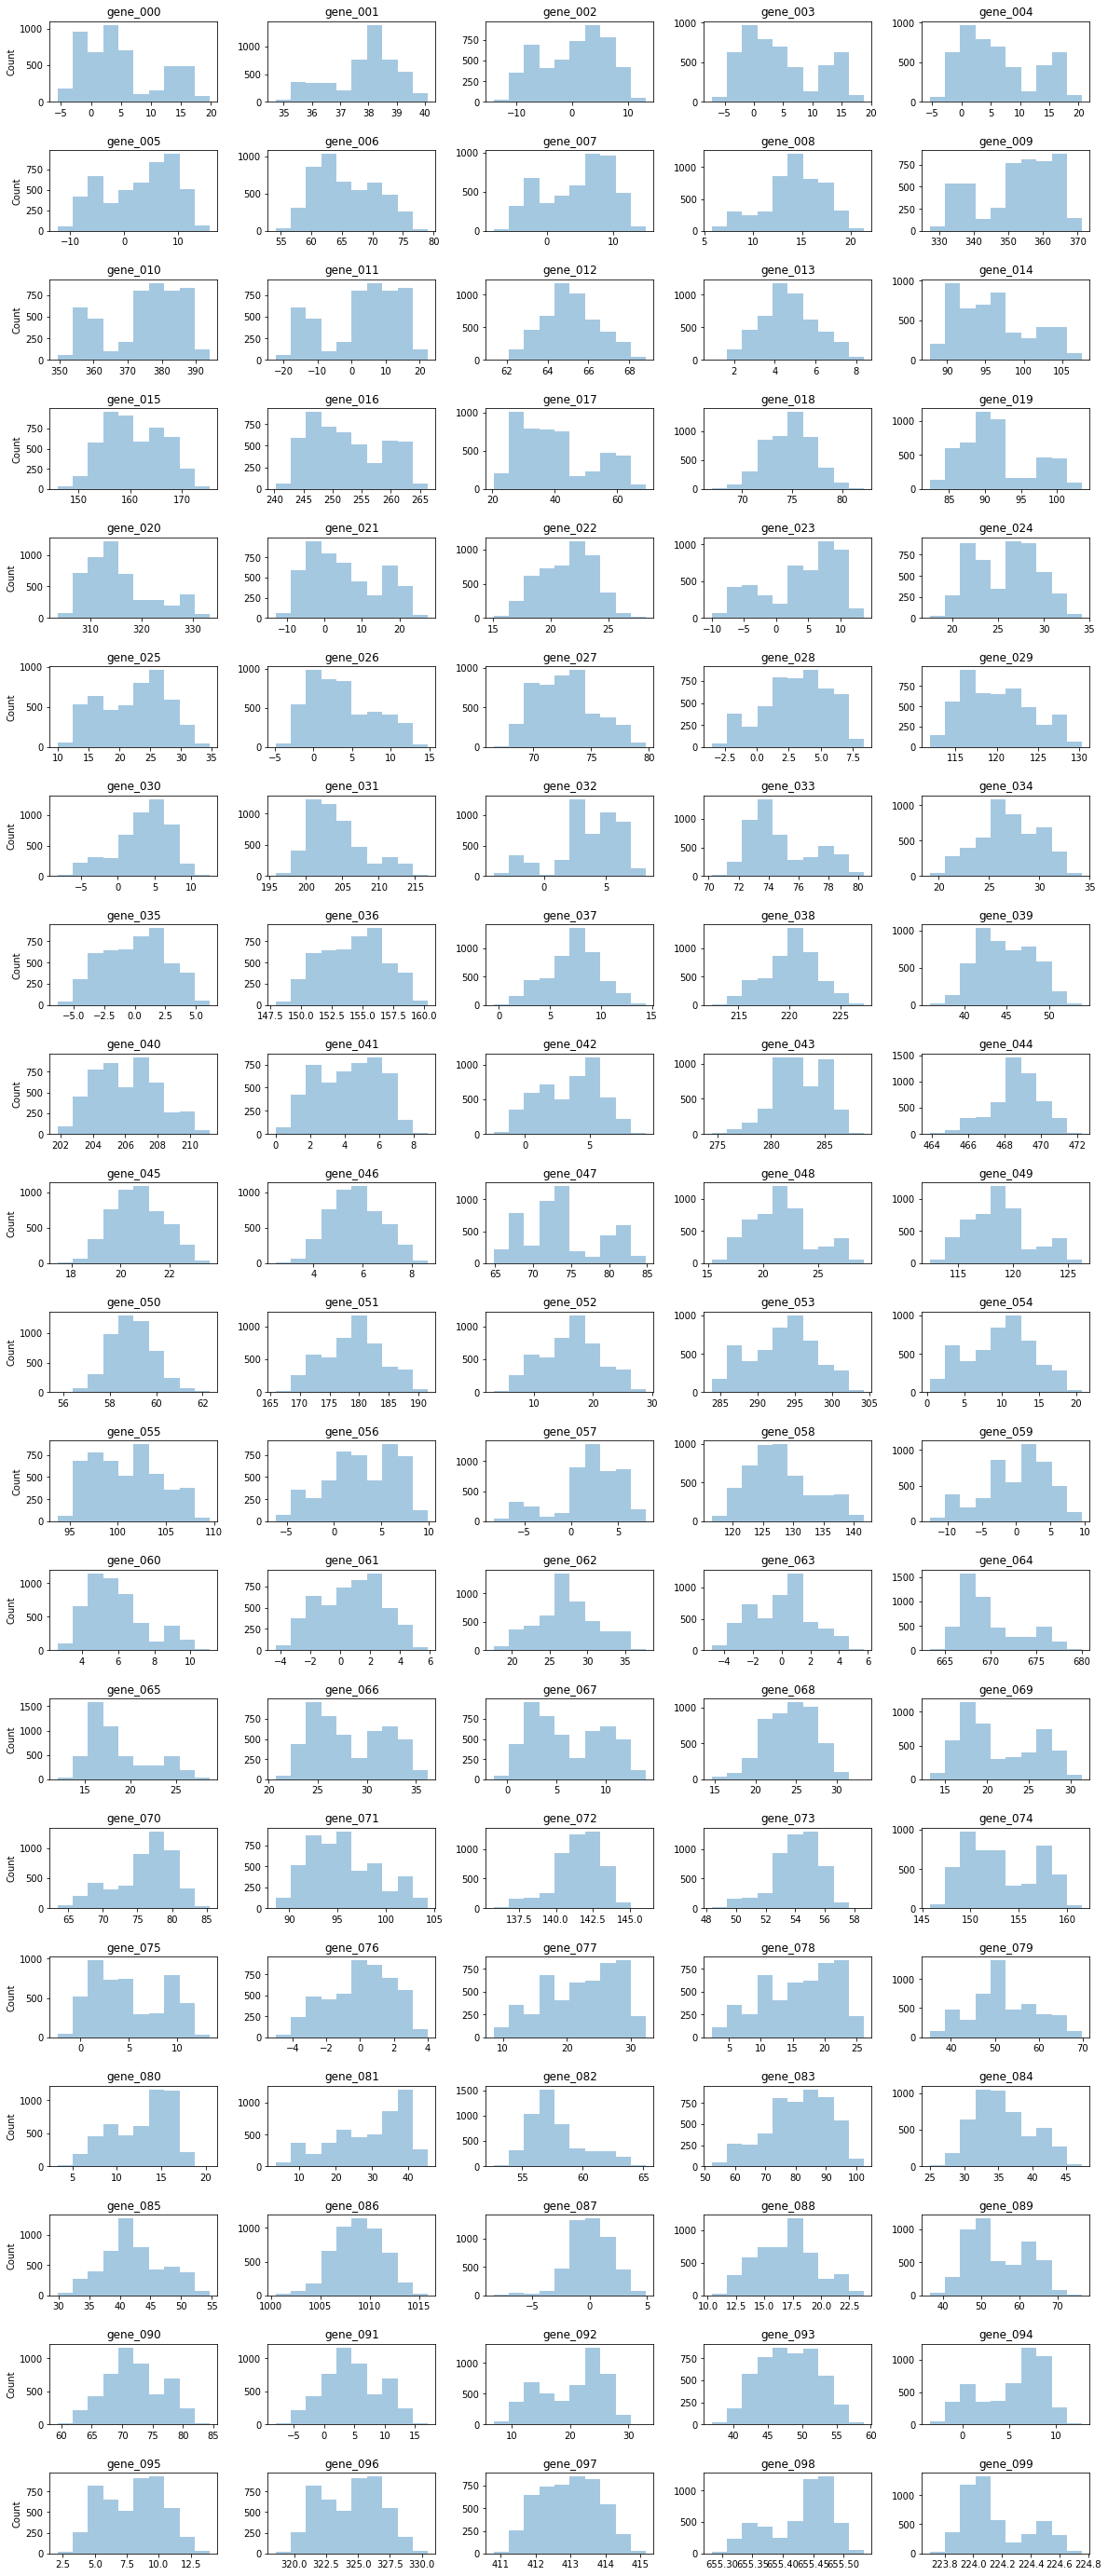

In [4]:
# Gene expression distributions
print('\nGene Expression Distributions:\n')
gene_expression_displot(df=pilotDataDF, n_col=5, bins=10, fig_width=20, fig_height=50, hspace=0.6, wspace=0.3)

## Missing Data
No missing data in this set.

In [6]:
# View missing data for 50 sample set - no missing data
print('Missing Data:')
sum(pilotDataDF.isnull().sum())

Missing Data:


0

## Standardize Data

In [8]:
scaler = StandardScaler()                    # Initialize scaler
X_scaled = scaler.fit_transform(pilotDataDF) # Train scaler and scale data

# Dimensionality Reduction with PCA
Many clustering algorithms (e.g. K-means) work poorly (or don't work at all) with high-dimensional data. Given that this data set contains 100 features, we will implement a dimensionality reduction step with PCA. Rather than aribtrarily selecting a number of dimensions to reduce down to we will keep the top dimensions (in terms of explained variance) that collectively explain 95% of the variance in the data set.

In [9]:
# Perform PCA preserving 95% explained variance
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_scaled)
X_reducedDF = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(len(X_reduced[0]))])
print(f'Dimensions remaining after dimensionality reduction: {len(X_reduced[0])}')

Dimensions remaining after dimensionality reduction: 6


# Clustering
## K-means
### Choosing Optimal Number of Clusters

Based on the plot below, the *optimal* number of clusters for K-means is 9; this is the point where there are diminishing returns in limiting the sum of squared distances (inertia) by increasing *k*. We'll proceed with using n_clusters=9 in our final K-means model.

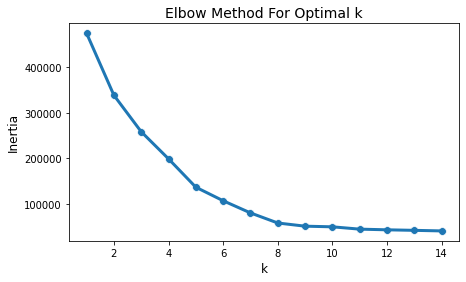

In [10]:
# Run k-means for n_cluster 1 to 15 and store corresponding inertia values
inertiaList = []
for k in range(1, 15):
    kmeans_clusterer = KMeans(n_clusters=k)
    kmeans = kmeans_clusterer.fit(X_reduced)
    inertiaList.append(kmeans.inertia_)

# Plot elbow curve
fig, ax = plt.subplots(figsize=(7, 4))
sns.lineplot(x=range(1, 15), y=inertiaList, linewidth=3)
sns.scatterplot(x=range(1, 15), y=inertiaList, s=60)
plt.xlabel('k', size=12)
plt.ylabel('Inertia', size=12)
plt.title('Elbow Method For Optimal k', size=14)
plt.show()

### K-Means Final Model

In [11]:
# Fit model
kmeans_clusterer = KMeans(n_clusters=9, random_state=0)
kmeans = kmeans_clusterer.fit(X_reduced)

# Display number of observations assigned to each cluster
kmeans_labels, kmeans_label_counts = np.unique(kmeans.labels_, return_counts=True)
pd.DataFrame({
    "Cluster": kmeans_labels,
    "Assigned to Cluster (n)": kmeans_label_counts
})

,Cluster,Assigned to Cluster (n)
0,0,106
1,1,485
2,2,667
3,3,595
4,4,543
5,5,728
6,6,717
7,7,620
8,8,433


In [12]:
X_reducedDF['kmeans_cluster'] = kmeans.labels_
X_reducedDF.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,kmeans_cluster
0,-5.544767,2.717605,-8.594973,-5.500864,6.647001,0.282942,8
1,-7.200475,-7.526954,2.624290,-1.114498,0.765139,0.113852,6
2,7.855053,6.302694,6.282120,-2.166174,1.453349,-0.308374,4
3,-7.459648,3.718405,-3.855239,1.108657,5.881422,0.589935,8
4,-5.884115,-5.344226,2.013932,-0.541739,-0.232778,-0.186916,6


### Cluster Visualization
Below we use a PCA biplot to visualize cluster assignments based on principal components 1 & 2. It seems like reasonable assignments have been made, although there is clear overlap in the clusters in 2D-space. Below we view cluster assignments in 3D-space to see if seemingly overlapping clusters are separated on principal component 3.

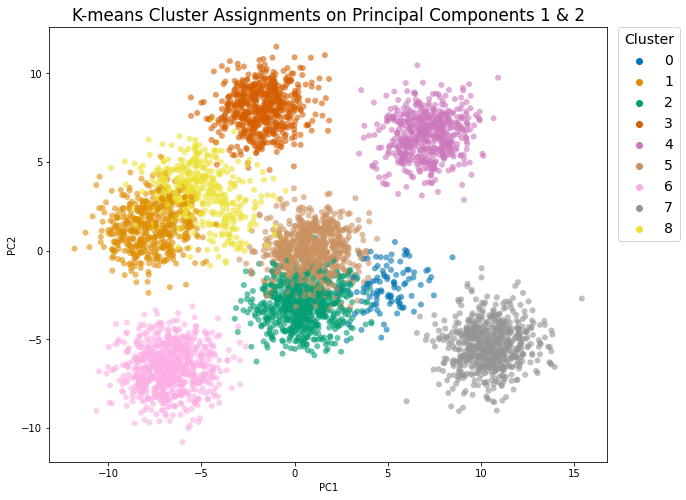

In [13]:
# Plot PCA with K-Means cluster assignments
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='kmeans_cluster', data=X_reducedDF, palette='colorblind', linewidth=0, alpha=.6)
plt.rcParams.update({'font.size': 14})
plt.title('K-means Cluster Assignments on Principal Components 1 & 2')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Cluster', borderaxespad=0)

As expected, the clusters are better separated when including PC3.

<IPython.core.display.Javascript object>


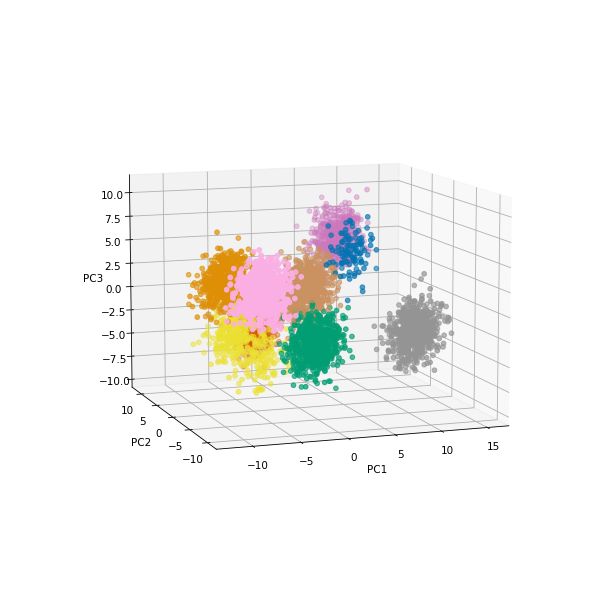

Text(0.5, 0, 'PC3')

In [14]:
#  Plot 3D PCA with K-Means cluster assignments
# Sources: 
# - https://stackoverflow.com/questions/1985856/how-to-make-a-3d-scatter-plot-in-matplotlib
# - https://stackoverflow.com/questions/38364435/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook

# This line of code is used to be able to rotate the 3D plot
%matplotlib notebook

# Create the figure space
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

# Plot the values
palette = ListedColormap(sns.color_palette('colorblind', 9).as_hex())
ax.scatter(X_reducedDF['PC1'], X_reducedDF['PC2'], X_reducedDF['PC3'], c=X_reducedDF['kmeans_cluster'].map(palette))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

## DBSCAN

### $\epsilon$ Selection
We will use the K-distance method to select an approximate 'optimal' value for $\epsilon$. In the K-distance plot below, we observe a knee at roughly distance = 2. We'll go ahead and use $\epsilon = 2$.

<IPython.core.display.Javascript object>


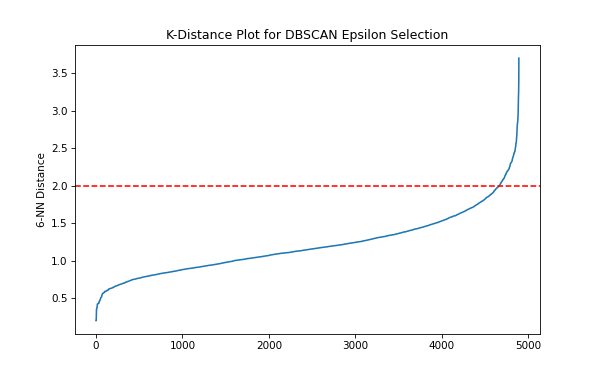

Text(0, 0.5, '6-NN Distance')

In [15]:
#%matplotlib inline

# Choosing min_points=6, the number of PCs in the reduced space
# Fit knn and extract distances
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(X_reduced)
distances, indices = neighbors_fit.kneighbors(X_reduced)

# Sort distances
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plot to find elbow
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x=range(1, len(distances) + 1), y=distances)
plt.axhline(y=2, c='r', linestyle='--')
#plt.xlim(3000, 5000)
#plt.ylim(1, 3)
plt.title('K-Distance Plot for DBSCAN Epsilon Selection')
plt.ylabel('6-NN Distance')

### DBSCAN Final Model
The DBSCAN algorithm denotes noise (i.e., outliers) with the -1 label. Roughly 5% of observations were labeled as noise here.

In [16]:
# Fit model
dbscan = DBSCAN(eps=2, min_samples=6)
dbscan.fit(X_reduced)

# Display number of observations assigned to each cluster
dbscan_labels, dbscan_label_counts = np.unique(dbscan.labels_, return_counts=True)
pd.DataFrame({
    "Cluster": dbscan_labels,
    "Assigned to Cluster (n)": dbscan_label_counts
})

,Cluster,Assigned to Cluster (n)
0,-1,369
1,0,687
2,1,503
3,2,276
4,3,564
5,4,588
6,5,1311
7,6,449
8,7,70
9,8,77


In [17]:
X_reducedDF['dbscan_cluster'] = dbscan.labels_
X_reducedDF.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,kmeans_cluster,dbscan_cluster
0,-5.544767,2.717605,-8.594973,-5.500864,6.647001,0.282942,8,-1
1,-7.200475,-7.526954,2.624290,-1.114498,0.765139,0.113852,6,0
2,7.855053,6.302694,6.282120,-2.166174,1.453349,-0.308374,4,1
3,-7.459648,3.718405,-3.855239,1.108657,5.881422,0.589935,8,2
4,-5.884115,-5.344226,2.013932,-0.541739,-0.232778,-0.186916,6,0


### Cluster Visualization

<IPython.core.display.Javascript object>


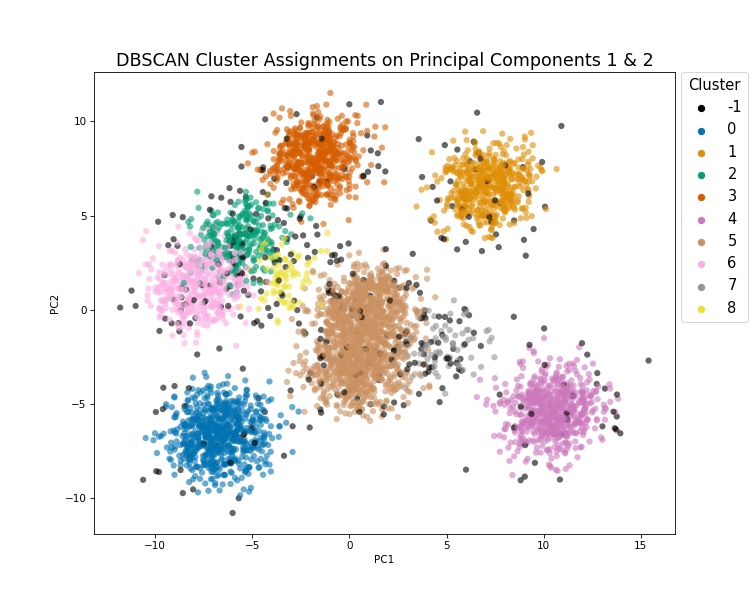

In [18]:
# Set palette with outlier set to black
palette = ['black']
for hex_code in list(sns.color_palette('colorblind', 9).as_hex()):
    palette.append(hex_code)

# Plot PCA with DBSCAN cluster assignments
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='dbscan_cluster', data=X_reducedDF, 
                palette=sns.color_palette(palette), linewidth=0, alpha=.6)
plt.rcParams.update({'font.size': 14})
plt.title('DBSCAN Cluster Assignments on Principal Components 1 & 2')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title='Cluster', borderaxespad=0)

## OPTICS

In [19]:
# Fit model
optics = OPTICS(cluster_method="dbscan", eps=2, min_samples=6)
optics.fit(X_reduced)

# Display number of observations assigned to each cluster
optics_labels, optics_label_counts = np.unique(optics.labels_, return_counts=True)
pd.DataFrame({
    "Cluster": optics_labels,
    "Assigned to Cluster (n)": optics_label_counts
})

,Cluster,Assigned to Cluster (n)
0,-1,375
1,0,77
2,1,276
3,2,563
4,3,1311
5,4,69
6,5,686
7,6,587
8,7,447
9,8,503


In [20]:
X_reducedDF['optics_cluster'] = optics.labels_
X_reducedDF.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,kmeans_cluster,dbscan_cluster,optics_cluster
0,-5.544767,2.717605,-8.594973,-5.500864,6.647001,0.282942,8,-1,-1
1,-7.200475,-7.526954,2.624290,-1.114498,0.765139,0.113852,6,0,5
2,7.855053,6.302694,6.282120,-2.166174,1.453349,-0.308374,4,1,8
3,-7.459648,3.718405,-3.855239,1.108657,5.881422,0.589935,8,2,1
4,-5.884115,-5.344226,2.013932,-0.541739,-0.232778,-0.186916,6,0,5


<IPython.core.display.Javascript object>


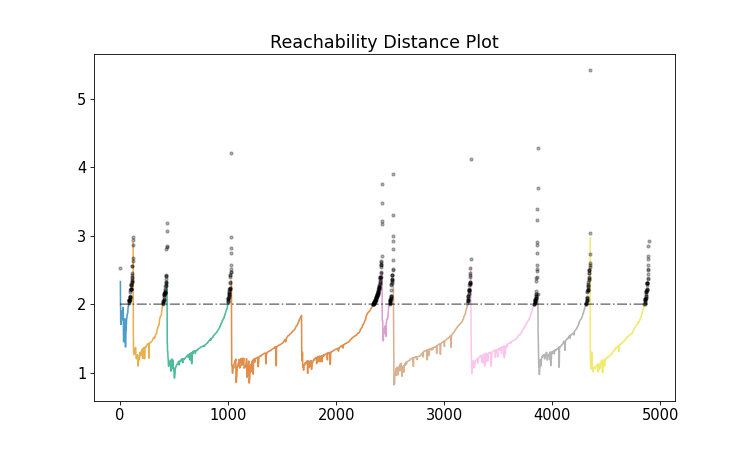

In [21]:
# Reachability plot 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py
# Get reachability information from clusterer
space = np.arange(len(X_reduced))
reachability = optics.reachability_[optics.ordering_]
labels = optics.labels_[optics.ordering_]

# Set figure space
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Reachability Distance Plot")

# Set palette
palette = list(sns.color_palette('colorblind', 9).as_hex())

# Plot clusters
for cluster, color in zip(range(0, 9), palette):
    Xk = space[labels == cluster]
    Rk = reachability[labels == cluster]
    ax.plot(Xk, Rk, color, alpha=0.7)
    
# Plot noise
ax.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
#ax.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax.plot(space, np.full_like(space, 2.0, dtype=float), "k-.", alpha=0.5)

In [22]:
labels

array([-1, -1,  0, ..., -1, -1, -1])

<IPython.core.display.Javascript object>


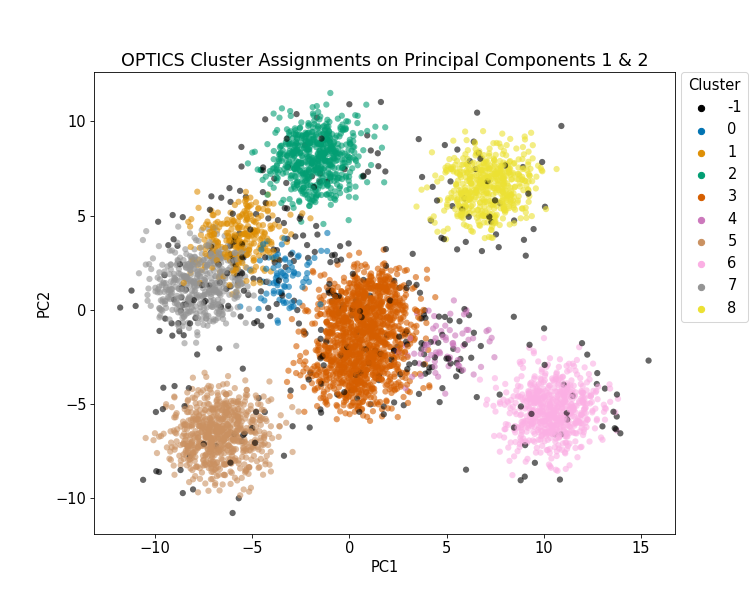

In [23]:
# Set palette with outlier set to black
palette = ['black']
for hex_code in list(sns.color_palette('colorblind', 9).as_hex()):
    palette.append(hex_code)

# Plot PCA with DBSCAN cluster assignments
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='optics_cluster', data=X_reducedDF, 
                palette=sns.color_palette(palette), linewidth=0, alpha=.6)
plt.rcParams.update({'font.size': 14})
plt.title('OPTICS Cluster Assignments on Principal Components 1 & 2')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title='Cluster', borderaxespad=0)